<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Machine Learning Models](#Machine-Learning-Models)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [1]:
import pandas as pd
import string
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


## Data Cleaning

### Import Data

In [2]:
# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Import data from our web scrapping jupyter notebook
df = pd.read_csv("../data/df.csv")

In [4]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.sample(10)

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class
1620,620,i was only able to fix my attachment style onl...,Hey guys I do believe loving yourself is essen...,yp0iw5,46,17,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
30,30,{DA} Vilification of avoidants and lack of tak...,This gets so exhausting. From popular resource...,125lfa9,165,81,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
266,266,Intensity {fa},Hey FAs! \nI kinda want to talk with you abo...,y1avbh,39,19,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
392,392,{FA} Indifferent to most people?,I feel like a good reason I'm so bad at talkin...,wo7s4r,32,12,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
64,64,{AP} or just too into me???,How many times a day do we see posts titled *D...,10ej3jr,84,17,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
45,45,"I started this sub, and now I’m just a filthy ...",But watching this sub grow to over 2.3k this p...,q9mpij,118,7,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
1460,460,what are some hard truths you've had to admit ...,"I know for myself, my protest behaviors \n\n(t...",zh2jym,58,32,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
674,674,{DA} Anxious-avoidant trap that's turned extre...,"I'm the DA, she's the AP. We're in couples the...",115bdbl,22,9,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0
1953,953,Hope for AAs,"I’m a formerly AP, moving to pretty secure, at...",118dzug,33,7,https://www.reddit.com/r/AnxiousAttachment/com...,AnxiousAttachment,1
824,824,What to do when anxious AND avoidant,New to this sub! I’ve noticed a trend in past ...,q2zzaa,18,5,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0


In [5]:
# Combine both the 'Title' and 'Post Text' columns for analysis

df["text"] = df["Title"] + ' ' + df["Post Text"].fillna('')

In [6]:
# Check that the X values ('text' column) and y values ('class' column) do not have missing values
df.isna().sum()

Unnamed: 0          0
Title               0
Post Text         283
ID                  0
Score               0
Total Comments      0
Post URL            0
subreddit           0
class               0
text                0
dtype: int64

In [7]:
# Check the number of rows for each class
df["class"].value_counts()

0    1000
1     998
Name: class, dtype: int64

In [8]:
# Dataframe info
df.describe()

,Unnamed: 0,Score,Total Comments,class
count,1998.000000,1998.000000,1998.000000,1998.000000
mean,499.000501,61.551552,19.877878,0.499499
std,288.459378,69.158604,23.499456,0.500125
min,0.000000,7.000000,0.000000,0.000000
25%,249.250000,27.000000,7.000000,0.000000
50%,499.000000,41.000000,14.000000,0.000000
75%,748.750000,65.000000,24.000000,1.000000
max,999.000000,986.000000,383.000000,1.000000


### Preprocessing

#### Remove special characters

In [9]:
# Remove punctuations and standardise to lowercase

def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

df["text_clean"] = df["text"].apply(lambda x: remove_punct(x.lower()))
df[["text", "text_clean"]].sample(5)

,text,text_clean
1572,I'm struggling to get over how my avoidant ex ...,im struggling to get over how my avoidant ex t...
1289,This sub became a circlejerk... I know you guy...,this sub became a circlejerk i know you guys w...
619,the idea of getting physical with someone make...,the idea of getting physical with someone make...
1102,The art of detaching I’ve started the process ...,the art of detaching i’ve started the process ...
1774,Anxiously attached people tend to experience m...,anxiously attached people tend to experience m...


#### Remove URLs

In [10]:
# Remove urls in the text column

def remove_url(text):
    text_nourl = re.sub(r'\S*http\S*', '', text)
    return text_nourl

df["text_clean"] = df["text_clean"].apply(lambda x: remove_url(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
1687,In defense of texting delays I don’t always re...,in defense of texting delays i don’t always re...
652,What irks you? {DA} {SA} {FA} As it says in th...,what irks you da sa fa as it says in the title...
505,{fa} I think I'm extremely triggered by differ...,fa i think im extremely triggered by differenc...
1360,Me and my avoidant bf broke up and I feel so f...,me and my avoidant bf broke up and i feel so f...
413,{FA} I feel terrified of relationships The wor...,fa i feel terrified of relationships the worst...
376,Feeling really down {DA} I don’t even know whe...,feeling really down da i don’t even know where...
186,Subreddit Reflections What a rollercoaster the...,subreddit reflections what a rollercoaster the...
1562,"Newly secure win. Hey friends. So, I've been w...",newly secure win hey friends so ive been worki...
1853,A reminder,a reminder
1963,I feel like I'm finally healing in a significa...,i feel like im finally healing in a significan...


#### Remove words that contains digit

In [11]:
def remove_digit(text):
    text_nodigit = re.sub(r'\w*\d\w*', '', text)
    return text_nodigit

df["text_clean"] = df["text_clean"].apply(lambda x: remove_digit(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
1023,My DA ex came back and I rejected him I got du...,my da ex came back and i rejected him i got du...
1403,Consistent communication = total game changer!...,consistent communication total game changer i...
1631,I thought I was a lot further along my healing...,i thought i was a lot further along my healing...
1225,"Are you really AP if you only start ""activatin...",are you really ap if you only start activating...
1140,Self soothing with words to validate the wound...,self soothing with words to validate the wound...
1034,Sometimes it's not your attachment system; som...,sometimes its not your attachment system somet...
610,Does anyone else get this way? {fa} I feel lik...,does anyone else get this way fa i feel like m...
1754,"people who were once anxiously attached, and h...",people who were once anxiously attached and ha...
1142,I realized that I was attached to the relation...,i realized that i was attached to the relation...
529,I was humbled by someone's vulnerability and i...,i was humbled by someones vulnerability and in...


#### Tokenize

In [12]:
def tokenize(text):  
    # /W matches any character that is neither alphanumeric nor underscoreb
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

df["text_token"] = df["text_clean"].apply(lambda x: tokenize(x)) 
df[["text", "text_token"]].sample(5)

,text,text_token
494,How can you trust your feelings in order to ma...,"[how, can, you, trust, your, feelings, in, ord..."
1310,But our connection and chemistry are unique......,"[but, our, connection, and, chemistry, are, un..."
1487,The most PAINFUL aspect of the Anxious/Avoidan...,"[the, most, painful, aspect, of, the, anxiousa..."
801,Love vs Attachment {FA} &#x200B;\n\nhttps://pr...,"[love, vs, attachment, fa, ]"
1755,Wow…I feel so seen. Thank you Just wanna say I...,"[wow, i, feel, so, seen, thank, you, just, wan..."


#### Remove Stopwords

In [13]:
# List of default stopwords
stopword = nltk.corpus.stopwords.words('english')

# Remove stop words
def remove_stopwords(tokenized_list):
    #Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

df["text_stop"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df[["text", "text_stop"]].sample(5)

,text,text_stop
1749,I have no one except my ex He said we could sp...,"[one, except, ex, said, could, spend, christma..."
741,"My Head is Spinning \nJust prior to moving, th...","[head, spinning, prior, moving, chemistry, ram..."
1134,I just want to turn it off. I (f27) feel like ...,"[want, turn, feel, like, losing, mind, try, ha..."
779,Do avoidants come back? How do avoidant attach...,"[avoidants, come, back, avoidant, attachment, ..."
617,Good date. Interesting to observe my reactions...,"[good, date, interesting, observe, reactions, ..."


#### Lemmatize

In [14]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    #return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return ' '.join(text)

df["text_lemmatise"] = df["text_stop"].apply(lambda x: lemmatizing(x))
df[["text", "text_lemmatise"]].sample(5)

,text,text_lemmatise
1806,How to stop ruminating on relationship mistake...,stop ruminating relationship mistake ghosting ...
1499,Had a long session w my new therapist last nig...,long session w new therapist last night think ...
11,Did this get shared here yet?- {sa}{DA},get shared yet sada
1669,Did you notice positive changes in the relatio...,notice positive change relationship learned se...
1634,Don't text them merry xmas Just dont\n\n&#x200...,dont text merry xmas dont edit ex people treat...


#### Remove duplicate words

In [15]:
# Identify duplicate words between both class
# Separate the text into two lists based on class
class_0_text = df[df['class'] == 0]["text_lemmatise"].tolist()
class_1_text = df[df['class'] == 1]["text_lemmatise"].tolist()

# Function to find and count duplicate words between both classes
def find_duplicate_words_between_classes(df, column_name, class_column_name):
    class_0_text = df[df[class_column_name] == 0][column_name].tolist()
    class_1_text = df[df[class_column_name] == 1][column_name].tolist()
    
    all_words_class_0 = ' '.join(class_0_text).split()
    all_words_class_1 = ' '.join(class_1_text).split()
    
    common_words = set(all_words_class_0).intersection(all_words_class_1)
    
    word_counts_class_0 = Counter(all_words_class_0)
    word_counts_class_1 = Counter(all_words_class_1)
    
    top_common_words_class_0 = {word: word_counts_class_0[word] for word in common_words if word in word_counts_class_0}
    top_common_words_class_1 = {word: word_counts_class_1[word] for word in common_words if word in word_counts_class_1}
    
    return pd.DataFrame({'Duplicate Words': list(common_words), 
                         'Count (Class 0)': [top_common_words_class_0.get(word, 0) for word in common_words],
                         'Count (Class 1)': [top_common_words_class_1.get(word, 0) for word in common_words]})

# Get the DataFrame containing duplicate words and counts for both classes
duplicate_words_df = find_duplicate_words_between_classes(df, "text_lemmatise", "class")

# Calculate the difference in counts between Class 0 and Class 1 for each word
duplicate_words_df['Count Difference'] = (duplicate_words_df['Count (Class 0)'] - duplicate_words_df['Count (Class 1)']).abs()

# Sort the DataFrame by the largest difference in counts (descending order)
duplicate_words_df = duplicate_words_df.sort_values(by='Count Difference', ascending=True)

# Display the duplicate words and counts for both classes
print(duplicate_words_df)
print(duplicate_words_df.shape)

           Duplicate Words  Count (Class 0)  Count (Class 1)  Count Difference
1219             stressing                3                3                 0
3768           maladaptive                4                4                 0
4635                 zoned                1                1                 0
1338            controlled                3                3                 0
4636           remembering                4                4                 0
2931           invalidates                1                1                 0
4638             witnessed                3                3                 0
1333                assume               20               20                 0
4640             delighted                1                1                 0
2933          complimented                1                1                 0
1327               consult                1                1                 0
4647           inspiration                2         

In [16]:
# Remove list of duplicate words (count difference less than 10)

additional_stopwords = duplicate_words_df[duplicate_words_df['Count Difference'].between(0, 10)]
stopword += additional_stopwords["Duplicate Words"].tolist()

df["text_final"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df["text_final"] = df["text_final"].apply(lambda x: lemmatizing(x))

#### Data for Machine Learning

In [17]:
# Final df for machine learning 
df.head()

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class,text,text_clean,text_token,text_stop,text_lemmatise,text_final
0,0,Seriously though {FA}{DA},NaN,tqnp1u,509,19,https://i.redd.it/vv5etnapy7q81.jpg,AvoidantAttachment,0,Seriously though {FA}{DA},seriously though fada,"[seriously, though, fada, ]","[seriously, though, fada, ]",seriously though fada,seriously though fada
1,1,For all my favorite avoidants ❤️,NaN,rpvbi1,447,2,https://i.redd.it/8yz268zr05881.jpg,AvoidantAttachment,0,For all my favorite avoidants ❤️,for all my favorite avoidants ❤️,"[for, all, my, favorite, avoidants, ]","[favorite, avoidants, ]",favorite avoidants,avoidants
2,2,Anxious People on this subreddit: stop abandon...,If you’re anxious preoccupied or anxious leani...,plr9xd,439,65,https://www.reddit.com/r/AvoidantAttachment/co...,AvoidantAttachment,0,Anxious People on this subreddit: stop abandon...,anxious people on this subreddit stop abandoni...,"[anxious, people, on, this, subreddit, stop, a...","[anxious, people, subreddit, stop, abandoning,...",anxious people subreddit stop abandoning blami...,anxious people subreddit stop someone else anx...
3,3,Same {FA},NaN,syzhtu,347,6,https://i.redd.it/ta0rdmnlhgj81.jpg,AvoidantAttachment,0,Same {FA},same fa,"[same, fa, ]","[fa, ]",fa,fa
4,4,And that’s on self development,NaN,r7y93d,327,6,https://i.redd.it/a9dh9u0oob381.jpg,AvoidantAttachment,0,And that’s on self development,and that’s on self development,"[and, that, s, on, self, development, ]","[self, development, ]",self development,self


In [18]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.shape

(1998, 15)

## Exploratory Data Analysis

#### EDA on Length and Word Count of post

In [19]:
# Create a new column called post_length that contains the length of each post
df['post_length'] = df['text_final'].map(len)

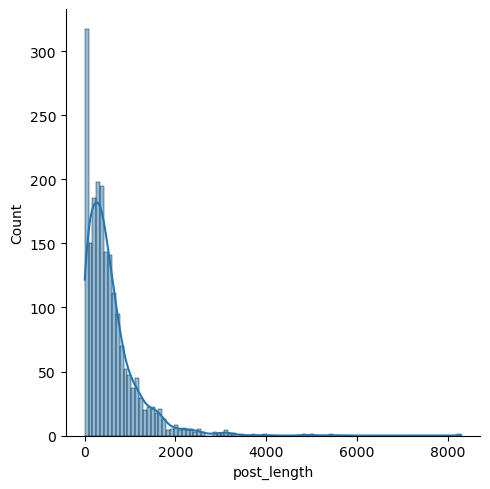

In [20]:
# Explore data on graphs
sns.displot(df['post_length'], kde=True)

In [21]:
# Create a new column called post_word_count that contains the number of words in each post
df['post_word_count'] = df['text_final'].map(lambda x: len(x.split()))

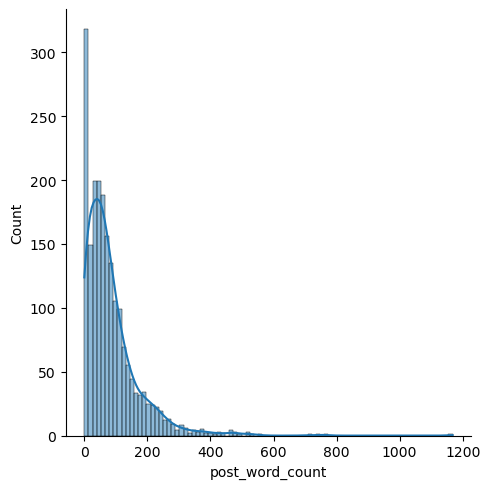

In [22]:
# Explore data on graphs
sns.displot(df['post_word_count'], kde=True)

#### EDA on Posts Content

In [23]:
# Show the five shortest posts based off of post_word_count
df.sort_values(by='post_word_count', ascending=True)[['text_final']].head()

,text_final
1094,
1061,
1668,
1032,
1008,


In [24]:
# Show the five longest posts based off of post_word_count
df.sort_values(by='post_word_count', ascending=False)[['text_final']].head()

,text_final
56,fa fa leaning da really say know da experience...
1652,checklist anxiously attached partner everyone ...
701,sibling relationship there tldr end behemoth t...
280,deactivation cohabitation fa ive posted lot re...
1660,attached review anxious leaner perspective wan...


#### EDA on Post Score

In [25]:
# Filter the DataFrame where 'Label' is equal to 0 (Anxious Attachment style)
filtered_df = df[df['class'] == 0]

# Sort the filtered DataFrame by 'Score' in ascending order and show the lowest posts scores
lowest_scores = filtered_df.sort_values(by='Score', ascending=True).head()

lowest_scores['text_final']

999    everyone feeling romantic love fa da sure ever...
998    da whining predicament think im bit im sure im...
997    feeling fa feel like sometimes try force self ...
996    phantom ex tell people da da phantom ex people...
995    dealing fa guilt dating time felt connected de...
Name: text_final, dtype: object

In [26]:
# Show the highest posts based off of post scores
#df.sort_values(by='Score', ascending=False).head()

# Filter the DataFrame where 'Label' is equal to 1 (Avoidant Attachment style)
filtered_df = df[df['class'] == 1]

# Sort the filtered DataFrame by 'Score' in ascending order and show the lowest posts scores
highest_scores = filtered_df.sort_values(by='Score', ascending=True).head()

highest_scores['text_final']

1989    reminder need see compassion ex feel missing n...
1986    know actually anxiously attached partner make ...
1962    avoidant bf good last finally broke avoidant b...
1995    best way anxiously attached breakup anxiously ...
1965    secure thought owned happiness time one secure...
Name: text_final, dtype: object

#### EDA on Duplicated Words

In [27]:
from nltk.tokenize import word_tokenize

class_0_text = df[df["class"] == 0]["text_lemmatise"].tolist()
class_1_text = df[df["class"] == 1]["text_lemmatise"].tolist()
# Tokenize the post text for class 1
tokens_class_1 = []
for text in class_1_text:
    tokens_class_1.extend(word_tokenize(text))
# Tokenize the post text for class 0    
tokens_class_0 = []
for text in class_0_text:
    tokens_class_0.extend(word_tokenize(text))
    
unique_tokens_class_1 = set(tokens_class_1)
unique_tokens_class_0 = set(tokens_class_0)

print(f"Unique words in class 0: {len(unique_tokens_class_0)-len(duplicate_words_df)}")
print(f"Unique words in class 1: {len(unique_tokens_class_1)-len(duplicate_words_df)}")
print(f"Duplicate words in both classes: {len(duplicate_words_df)}")

Unique words in class 0: 4050
Unique words in class 1: 2927
Duplicate words in both classes: 5302


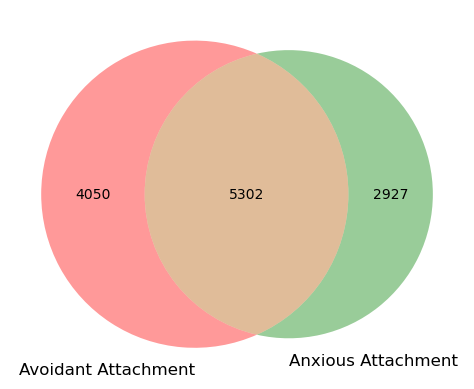

In [28]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

venn2(subsets = (4050, 2927,5302), set_labels = ('Avoidant Attachment', 'Anxious Attachment'))

#### Word Cloud - Anxious Style

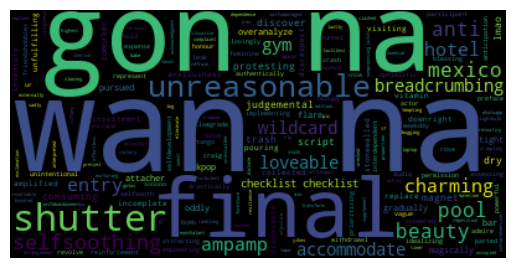

In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

duplicate_word_list = list(duplicate_words_df["Duplicate Words"])
class_1_words = [word for word in tokens_class_1 if word not in duplicate_word_list]

# For Anxious Attachment class 1
text = " ".join(class_1_words)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud - Avoidant Style

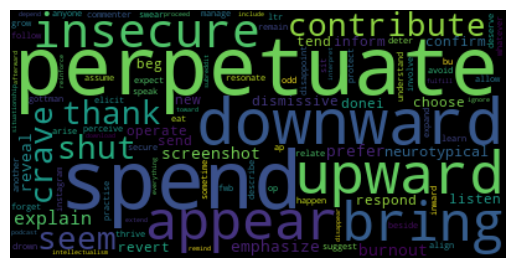

In [30]:
# For Avoidant Attachment class 0

class_0_words = [word for word in tokens_class_0 if word not in duplicate_word_list]

text = " ".join(unique_tokens_class_0)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning Models

### Count Vectorizer & Naive Bayes (Bernoulli) Pipeline

#### Baseline Model 

In [31]:
# Initiate train, test, split function
X = df['text_final']
y = df['class']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [32]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Bernoulli)
pipe_cv_berNB = Pipeline([
    ('cvec',  CountVectorizer()),
    ('berNB', BernoulliNB())])
# Define hyperparameters for grid search
pipe_cv_berNB_params = {'cvec__max_features' : [500],  # 100
                        'cvec__ngram_range' : [(1,2)], #(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)
                       'berNB__binarize': [0.0]}       # 0.1, 0.5

# Instantiate GridSearchCV
gs_cv_berNB = GridSearchCV(pipe_cv_berNB, pipe_cv_berNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_berNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_berNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_berNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_berNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_berNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_berNB = gs_cv_berNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_berNB))

Best Score: 0.7917101449275362
Best Parameters: {'berNB__binarize': 0.0, 'cvec__max_features': 500, 'cvec__ngram_range': (1, 2)}
Train Score: 0.8210947930574098
Test Score: 0.79
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       250
           1       0.77      0.83      0.80       250

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



### Count Vectorizer & Naive Bayes (Multinomial) Pipeline

In [33]:
# Create a pipeline for Count Vectorizer and Naive Bayes (Multinomial)
pipe_cv_multiNB = Pipeline([
    ('cvec',  CountVectorizer()), 
    ('multiNB', MultinomialNB())])

# Define hyperparameters for grid search
pipe_cv_multiNB_params = {'cvec__max_features' : [100,500],  # comment what you have tried
                        'cvec__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)]}
                        

# Instantiate GridSearchCV    
gs_cv_multiNB = GridSearchCV(pipe_cv_multiNB, pipe_cv_multiNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_multiNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_multiNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_multiNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_multiNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_multiNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_multiNB = gs_cv_multiNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_multiNB))

Best Score: 0.809748049052397
Best Parameters: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 2)}
Train Score: 0.8457943925233645
Test Score: 0.81
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       250
           1       0.83      0.78      0.80       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



### TF-IDF Vectorizer & Logistic Regression Model

#### Best Model

In [34]:
def tfidvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Tfidf Vectorizer
    vectorizer = TfidfVectorizer(max_features=450, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    #Step 5: Retrieve the coefficient and feature names 
    coef = classifier.coef_[0]
    features = vectorizer.get_feature_names_out() 
    feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})
    # Separate positive and negative coefficients
    positive_coeffs = feature_importance[feature_importance['Importance'] > 0]
    negative_coeffs = feature_importance[feature_importance['Importance'] < 0]
    # Find the smallest positive coefficient
    largest_positive_coeff = positive_coeffs.nlargest(50, 'Importance')
    # Find the highest negative coefficient
    smallest_negative_coeff = negative_coeffs.nsmallest(50, 'Importance')
    
    
    # Step 6: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    return train_accuracy, test_accuracy, smallest_negative_coeff, largest_positive_coeff


# Invoke Function 
tfidvectorize_split_smote_logistic(X,y)

Train Score: 0.8883333333333333
Test Score: 0.8325
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       400
           1       0.83      0.83      0.83       400

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



(0.8883333333333333,
 0.8325,
                 Features  Importance
 148                   fa   -5.878790
 95                    da   -3.278871
 42              avoidant   -2.838366
 44             avoidants   -2.213543
 41             avoidance   -2.111795
 43   avoidant attachment   -1.638547
 153              feeling   -1.602595
 151                 feel   -1.407740
 102         deactivation   -1.373204
 136                 ever   -1.249475
 126              emotion   -1.245172
 40                 avoid   -1.241785
 330                  run   -1.153991
 114           dismissive   -1.147283
 267                  mom   -1.129183
 101         deactivating   -1.096668
 287               others   -1.007298
 254                 many   -1.005068
 155                 felt   -0.981302
 75                 close   -0.979997
 394             tendency   -0.976230
 96                   dad   -0.950459
 88          conversation   -0.939272
 383                style   -0.919704
 68                 

## Conclusions and Recommendations